# Klasteryzacja - Raport

Konrad Welkier, Piotr Sieńko, Jacek Wiśniewski

## 1. Wstęp

Badany zbiór danych pochodzi ze strony https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#, opisuje on 12,330 sesji użytkowników przeglądarek internetowych. Posiada on 10 zmiennych numerycznych oraz 8 kategorycznych, które zawierają różnego rodzaju dane dotyczące sposobu i czasu odwiedzania stron internetowych, stosowanego oprogramowania oraz informację, czy klient dokonał transakcji zakupu w czasie trwania danej sesji. Jest to naturalny sposób rozdziału klientów na tych, którzy przynoszą i nie przynoszą zysków. Postanowiliśmy więc sprawdzić w jakim stopniu podział uzyskany za pomocą metod klasteryzacji jest podobny do oryginalego.

W tym celu przetestowaliśmy następujące algorytmy klasteryzacyjne:

- **K-średnich** -> w czasie każdej iteracji przyporządkowuje obserwacje do najbliższych skupień, następnie oblicza centroidy uzyskanych grup, które stają się nowymi środkami. Algorytm należy kilkakrotnie powtórzyć w celu eliminacji błędu początkowego wyboru punktów skupień.
- **Gaussian mixture model** -> za pomocą własności rozkładu normalnego, zwraca prawdopodobieństwo przyporządkowania punktów do określonego skupienia 
- **Algorytm aglomeracyjny** -> każdy punkt jest początkowo oddzielnym klastrem. Stopniowo łączy najbliższe klastry, aż do uzyskania zadanej ich liczby.

Do oceny wyników klasteryzacji użyliśmy następujących metryk:
- **Indeks Silhouette** ->  średnia miara tego jak dany punkt pasuje do przydzielonego klastra, w porównaniu z drugim najlepszym wyborem. Im wyższy wynik tym lepsza klasteryzacja.

- **Indeks Daviesa-Bouldina** -> opisuje średnie podobieństwo pomiędzy każdym klastrem. Im niższy wynik tym lepsza klasteryzacja

- **Skorygowany indeks Randa** -> jedyna używana przez nas miara, która porównuje podział uzyskany z oryginalnym. Oblicza podobieństwo pomiędzy obydwoma podziałami. Jeśli są identyczne, indeks przyjmuje wartość 1.

Dodatkowo, do wizualizacji wyników użyliśmy analizy głównych składowych.

## 2. Pytanie Badawcze

Czy podział zbioru uzyskany metodami klasteryzacji odzwierciedla rzeczywiste grupy klientów?

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

## 3. Przygotowanie danych

W celu polepszenia działania algorytmów, ustandaryzowaliśmy zmienne numeryczne oraz zgrupowaliśmy rzadziej występujące przeglądarki i systemy operacyjne. 

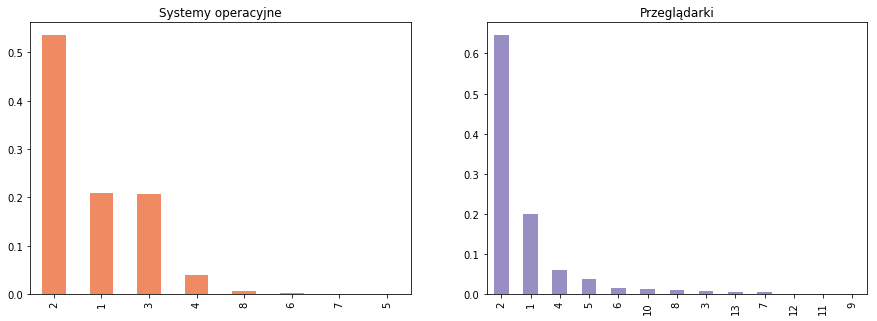

In [32]:
raw_data = pd.read_csv("online_shoppers_intention.csv")
result = raw_data.Revenue.astype(int)


fig, ax =plt.subplots(1,2, figsize = (15, 5))
raw_data.iloc[:,11].value_counts(normalize = True).plot.bar(ax = ax[0], color = "#ef8a62")
raw_data.iloc[:,12].value_counts(normalize = True).plot.bar(ax = ax[1], color = "#998ec3")
ax[0].set_title("Systemy operacyjne")
ax[1].set_title("Przeglądarki")

fig.show()

Usunęliśmy również kolumny, które w bardzo niewielkim stopniu różnicowały nam zbiór danych, lub były pośrednio zakodowane w innych zmiennych

In [33]:
raw_data = pd.read_csv("online_shoppers_intention.csv")
result = raw_data.Revenue.astype(int)

# Usuwanie zmiennej celu + informacji nie wpływających na wynik
data = raw_data.drop(["Revenue", "Month", "Weekend", "VisitorType"], axis = 1)

# Usuwanie zmiennych zakodowanych w innych zmiennych
data = data.drop(["Informational", "Administrative", "ProductRelated"], axis = 1)

# Zostawiamy tylko 3 główne przeglądarki internetowe i systemy operacyjne
data.loc[~data.Browser.isin([1,2,3]),'Browser'] = -1
data.loc[~data.OperatingSystems.isin([1,2]),'OperatingSystems'] = -1

# Standaryzowanie 
Standarized = pd.DataFrame(data[['ExitRates','PageValues', 'SpecialDay', 'BounceRates',
                               'Administrative_Duration',"Informational_Duration", "ProductRelated_Duration"]])
Standarized = StandardScaler().fit_transform(Standarized)

data[['ExitRates','PageValues', 'SpecialDay', "BounceRates", 
   "Administrative_Duration","Informational_Duration", "ProductRelated_Duration"]] = Standarized

data.head()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
0,-0.457191,-0.244931,-0.624348,3.667189,3.229316,-0.317178,-0.308821,1,1,1,1
1,-0.457191,-0.244931,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,2,2,1,2
2,-0.457191,-0.244931,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1,1,9,3
3,-0.457191,-0.244931,-0.622954,0.573535,1.994610,-0.317178,-0.308821,-1,2,2,4
4,-0.457191,-0.244931,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,-1,3,1,4


## 4. Dobór liczby klastrów

Wszystkie używane przez nas algorytmy wymagają podania liczby klastrów. Musieliśmy więc w jak najbardziej obiektywny sposób wybrać na ile podzbiorów chcemy podzielić nasze dane. Do tego celu użyliśmy miary silhouette oraz metody "łokciowej".

In [3]:
def silhouette_method_for_kmeans(df, k_max):
    """
    functions prepares plot showing silhouette score for each number of clusters from 1 up to k_max
    """
    scores = []    
    for k in range(2, k_max):
        kmeanModel = KMeans(n_clusters=k)
        labels = kmeanModel.fit_predict(df)
        wcss = silhouette_score(df, labels)
        scores.append(wcss)
    plt.plot(range(2, k_max), scores, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.xticks(ticks=np.arange(2, 20, 1))
    plt.title("The Silhouette Method showing the optimal k")
    return plt

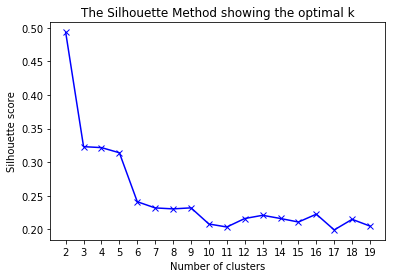

In [4]:
silhouette_method_for_kmeans(data, 20).show()

In [5]:
def elbow_method(df, k_max):
    """
    function that prepares plot showing distortions for each number of clusters from 1 up to k_max
    """
    distortions = []
    for k in range(1, k_max):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize = (10,5))
    plt.plot(range(1, k_max), distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.xticks(ticks=np.arange(2, 20, 1))
    plt.title('The Elbow Method showing the optimal k')
    return plt

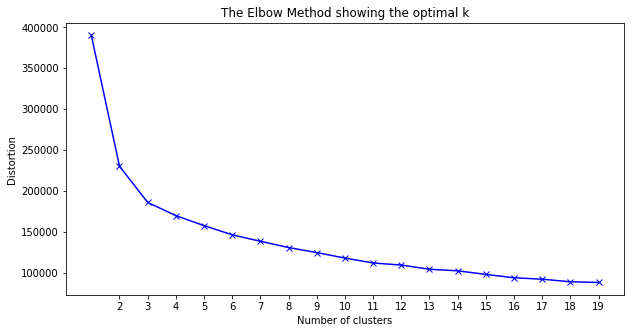

In [6]:
elbow_method(data, 20).show()

Obie metody wskazują k = 2, jako najlepszą liczba klastrów. Możliwe więc, że w naszym zbiorze danych uda się podzielić klientów na kupujących i tylko odwiedzających.

## 5. Pierwsze modele

Po przygotowaniu danych oraz znalezieniu optymalnej liczby klastrów, stworzyliśmy dwa wstępne modele, wykorzystujące metodę K-średnich oraz GMM. 

In [7]:
def model(data, algorithm):
    if algorithm == "KMeans":
        model = KMeans(n_clusters = 2, random_state=0, init = 'random', n_init = 10)
    elif algorithm == "AgglomerativeClustering":
        model = AgglomerativeClustering(n_clusters=2)
    elif algorithm == "GaussianMixture":
        model = GaussianMixture(n_components=2, covariance_type='full')
    y_agg = model.fit_predict(data)
    
    
    print("Adjusted Rand score -> " + str(metrics.adjusted_rand_score(result, y_agg)))
    print("Silhoute score -> " + str(silhouette_score(data, y_agg)))
    print("Davies-Bouldin Score -> " + str(metrics.davies_bouldin_score(data, y_agg)))
    print("      ")
    df2 = pd.DataFrame({'nasz' : y_agg, 'prawdziwy': result})

    # Crosstab - odpowiednik macierzy TP,TN,FP,FN
    ct = pd.crosstab(df2['nasz'], df2['prawdziwy'])

    print(ct)
    return(y_agg)

In [8]:
kmeans = model(data, "KMeans")

Adjusted Rand score -> 0.002914198259632032
Silhoute score -> 0.49335301746555515
Davies-Bouldin Score -> 0.8896926379870409
      
prawdziwy     0     1
nasz                 
0          8654  1575
1          1768   333


In [9]:
gmm = model(data, "GaussianMixture")

Adjusted Rand score -> 0.24542104703463424
Silhoute score -> 0.038170524727392574
Davies-Bouldin Score -> 5.268457629172635
      
prawdziwy     0     1
nasz                 
0          2669  1659
1          7753   249


Wyniki były bardzo słabe, oba algorytmy nie zdołały podzielić zbioru na wyróżniające się, oddzielone od siebie klastry. Metoda K-średnich miała o wiele wyższy indeks Silhouette, lecz niestety indeks Randa był bliski zeru. Odwrotnie wyglądały wyniki Gaussian Mixture Model. Po uzyskanych wartościach widać, że oba algorytmy zadziałały zupełnie inaczej. Aby sprawdzić różnice między nimi, zdecydowaliśmy się na użycie analizy głównych składowych i graficzne przedstawienie ich działania.

In [10]:
def draw_pca(data, prediction1, prediction2, title1, title2):
    pca = PCA(n_components= 3)
    pca.fit(data)
    pca_features = pca.transform(data)
    
    xs = pca_features[:,0]
    ys = pca_features[:,1]
    zs = pca_features[:,2]

    # Rysujemy 
    fig = plt.figure(figsize=(18, 8))

    ax = fig.add_subplot(1, 2, 1, projection = '3d')
    ax.scatter(xs, ys, zs, c = prediction1)
    ax.title.set_text(title1)

    ax = fig.add_subplot(1, 2, 2, projection = '3d')
    ax.scatter(xs, ys, zs, c = prediction2)
    ax.title.set_text(title2)

    plt.show()

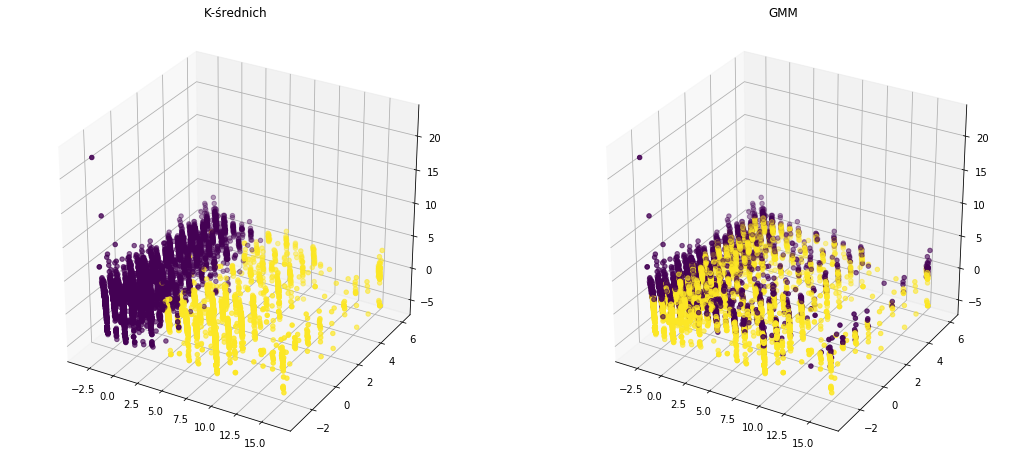

In [11]:
draw_pca(data, kmeans, gmm, 'K-średnich', 'GMM')

Oba podziały są od siebie kompletnie różne. GMM posiadający wyższy indeks Randa, podzielił zbiór według wartości wektora pionowego. Zmienną, która w dużym stopniu warunkuje jego wartość jest _PageValues_. Postanowiliśmy zwiększyć jej znaczenie i sprawdzić, czy wpłynie to na lepszy podział zbioru. Po wielu próbach, do tej części eksperymentu wybraliśmy algorytm aglomeracyjny oraz używany wcześniej K-średnich.

## 6. Modele ze zwiększonym page value

In [12]:
import copy 

data_modified = copy.deepcopy(data)
data_modified.loc[:, "PageValues"] = data_modified.loc[:, "PageValues"] * 20

In [13]:
kmeans2 = model(data_modified, "KMeans")

Adjusted Rand score -> 0.3090556140115334
Silhoute score -> 0.8226984845752094
Davies-Bouldin Score -> 0.508916392470719
      
prawdziwy      0     1
nasz                  
0          10270  1365
1            152   543


In [14]:
agg = model(data_modified, "AgglomerativeClustering")

Adjusted Rand score -> 0.22196899478319693
Silhoute score -> 0.8388445443280641
Davies-Bouldin Score -> 0.4675237227827504
      
prawdziwy      0     1
nasz                  
0          10336  1545
1             86   363


Okazało się, że tak drobna zmiana miała ogromny wpływ na działanie. Indeks Silhouette osiągnął ponad 0.8, natomiast indeks Daviesa - Bouldina zmalał w okolice 0.5. 

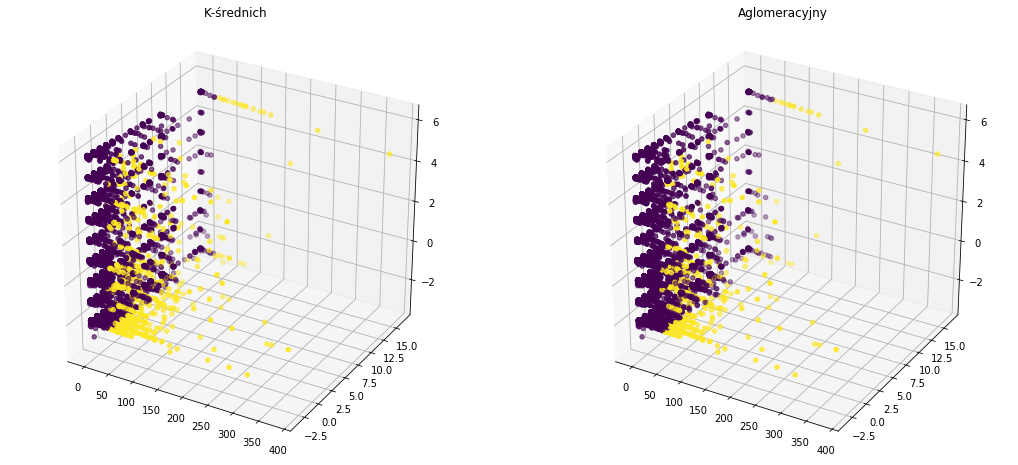

In [15]:
draw_pca(data_modified, kmeans2, agg, 'K-średnich', 'Aglomeracyjny')

Oba algorytmy w podobny sposób rozbiły punkty na klastry. Widać, że obserwacje są podzielone wzdłuż zmodyfikowanego wektora. Upewnijmy się jeszcze, że dla tak zmienionych danych, opytmalną liczbą klastrów jest 2.

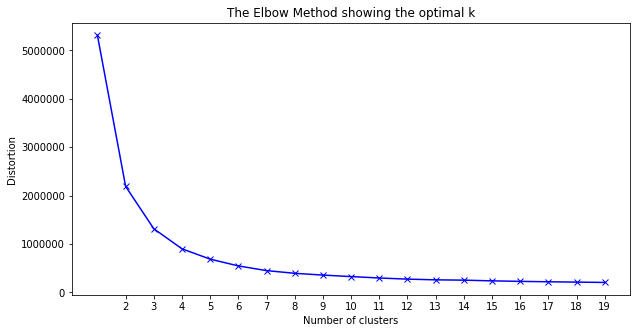

In [16]:
elbow_method(data_modified, 20).show()

Metoda 'łokciowa' znów wskazała k = 2. Przyjmijmy więc, że jest to optymalna liczba klastrów.

## 7. Weryfikacja hipotezy badawczej i wnioski

Pozostało nam sprawdzenie, czy rzeczywiste rozbicie na klientów, którzy dokonali zakupu i tych, którzy nie zakończyli transakcji jest możliwe do odwzorowania przy użyciu klasteryzacji. Do porównania z oryginalnym podziałem wybraliśmy algorytm K-śrendnich.

In [19]:
model = KMeans(n_clusters = 2, random_state=0, init = 'random', n_init = 10)
kmeans = model.fit_predict(data_modified)
    
    
print("Adjusted Rand score -> " + str(metrics.adjusted_rand_score(result, kmeans)))
print("Silhoute score -> " + str(silhouette_score(data_modified, kmeans)))
print("Davies-Bouldin Score -> " + str(metrics.davies_bouldin_score(data_modified, kmeans)))
print("      ")

print("Accuracy -> " + str(metrics.accuracy_score(result, kmeans)))
print("Precision -> " + str(metrics.precision_score(result, kmeans)))
print("Recall -> " + str(metrics.recall_score(result, kmeans)))
print("      ")
df2 = pd.DataFrame({'nasz' : kmeans, 'prawdziwy': result})

# Crosstab - odpowiednik macierzy TP,TN,FP,FN
ct = pd.crosstab(df2['nasz'], df2['prawdziwy'])

print(ct)

Adjusted Rand score -> 0.3090556140115334
Silhoute score -> 0.8226984845752094
Davies-Bouldin Score -> 0.508916392470719
      
Accuracy -> 0.8769667477696674
Precision -> 0.781294964028777
Recall -> 0.28459119496855345
      
prawdziwy      0     1
nasz                  
0          10270  1365
1            152   543


W końcowym porównaniu użyliśmy również miar znanych nam z zadań klasyfikacji.

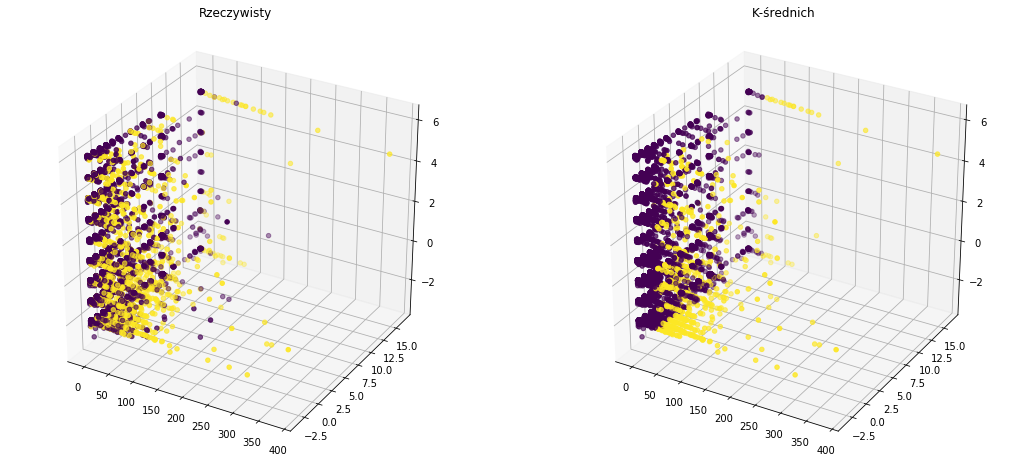

In [18]:
draw_pca(data_modified, result, kmeans2, 'Rzeczywisty', 'K-średnich')

Wyniki nie są jednoznaczne. Na podstawie przeprowadzonych eksperymentów można stwierdzić, że zwiększenie wagi zmiennej _PageValues_ poprawia działanie algorytmów klasteryzujących. Osiągnęliśmy podział, który wydaje się być na pierwszy rzut oka podobny do oryginalnego. Niestety, rzeczywiste rozdzielenie podzbiorów na dany typ klienta jest znacznie bardziej skomplikowane. Pamiętajmy również, że dane zostały zmodyfikowane na podstawie indeksu Randa, który wykorzystuje wiedzę o prawdziwym podziale zbioru. Niestety w praktyce rzadko kiedy dysponujemy takimi danymi. Podsumowując, możemy przyjąć, iż wyniki działania algorytmów klasteryzujących nie odzwierciedlają rzeczywistego podziału zbioru względem typu klienta.

## Oświadczenie

Oświadczamy, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia się z przedmiotu Wstęp do Uczenia Maszynowego została wykonana przeze nas samodzielnie.

Konrad Welkier, Piotr Sieńko, Jacek Wiśniewski